# MNIST solution exploration [0.99542]

This kernel was created with the intention on exploring different CNNs to have a benchmark on what works best on a dataset of this kind of images (i.e. numbers, characters, etc.). I started using a fully connected network followed by a CNN network I had used in the past for the MNIST dataset when I was studing a Machine Learning Nanodegree from Udacity. From that point on, I wanted to try to extend  that CNN with new ideas, which I mainly took from some notebooks (mentioned below).<br>
I saw a couple of different notebooks but decided to try to reproduce on my own those ideas that I found to be more interesting and that were something completely new to me. I was actually expecting to see some improvements on my predictions as I was introducing these ideas to this kernel (or a combination of them). Unfortunatelly I found out (as it should be expected by some other more experienced kaggler), that a combination of such ideas do not necessarily bring an improvement or sometimes the improvement comes with a (significant) additional computational cost.<br><br>
The kernels from which I decided to  take some ideas are:<br>
* [deep-neural-network-keras-way](https://www.kaggle.com/poonaml/deep-neural-network-keras-way/notebook)
* [25 Million Images! \[0.99757\] MNIST](https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist)
* [How to choose CNN Architecture MNIST](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist)

I found particularly interesting and full of insight those notebooks from Chris Deotte.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils as tf_utils
from keras.callbacks.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras import regularizers


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv


## Loading the data...

In [2]:
mnist_train_complete = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
mnist_test_complete = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

mnist_train_complete.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# preparing the training and testing sets, separating the training pictures of the numbers (i.e. train_x)
# from their label (i.e train_y).
# We set here also the data types as int32
train_y = mnist_train_complete.iloc[:, 0].values.astype('int32')
train_x = mnist_train_complete.iloc[:, 1:].values.astype('float32')
test_x = mnist_test_complete.values.astype('float32')

# reshaping the training and testing sets to have each digit image of 28 by 28 pixels
train_x = train_x.reshape(train_x.shape[0], 28, 28)
test_x = test_x.reshape(test_x.shape[0], 28, 28)

## Visualizing some digit images

How does an image of this dataset looks like actually?

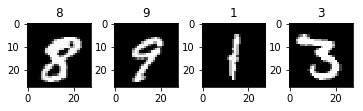

In [4]:
for i in range (10,14):
    plt.subplot(330 + i+1)
    plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
    plt.title(train_y[i])

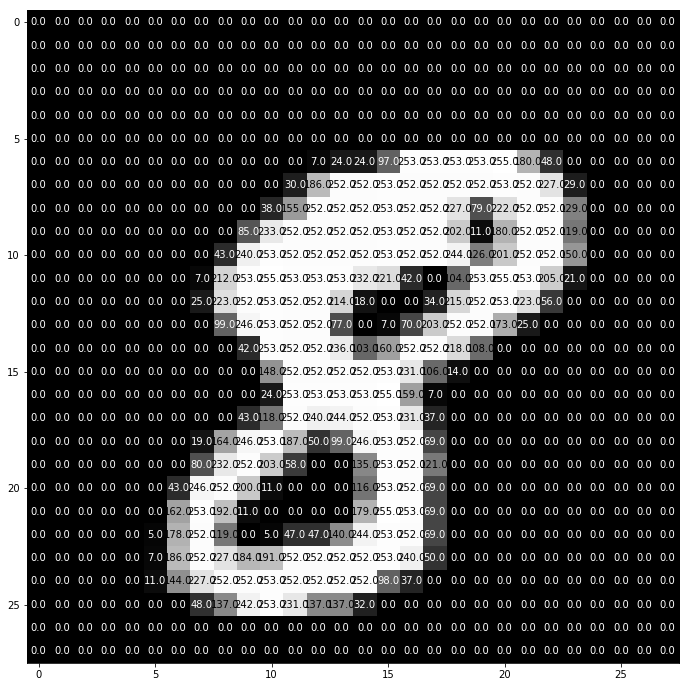

In [5]:
def visualize_detail(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    threshold = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y], 2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y] < threshold else 'black')

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
    
visualize_detail(train_x[10], ax)

## Preprocessing

In [6]:
# Normalizing the training and testing sets
train_x = train_x.astype('float32')/np.max(train_x)
test_x = test_x.astype('float32')/np.max(test_x)

# center the normalized data around zero
mean = np.std(train_x)
train_x -= mean
mean = np.std(test_x)
test_x -= mean

In [7]:
# creating the training and validationg sets
splitted_train_X, splitted_test_X, splitted_train_y, splitted_test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=81)

# one-hot encoding the training and validation sets
ohe_splitted_train_y = tf_utils.to_categorical(splitted_train_y, 10)
ohe_splitted_test_y = tf_utils.to_categorical(splitted_test_y, 10)

# print first one-hot training labels
print('One-hot labels:')
print(splitted_train_y[:10])

One-hot labels:
[4 8 0 1 4 1 7 0 5 8]


## Solution 1. Model using fully connected NNs

To begin with, I will try a fully connected NN consisting of a layer of 512 neurons, followed by a dropout of 20%, followed by another layer of 512 neurons and another dropout of 20% and finally a layer of 10 neurons with softmax activation. Both the first layers of 512 neurons have 'relu' activation.

In [8]:
# define a fully connected NNs model
model_sol_1 = tf.keras.models.Sequential()
model_sol_1.add(tf.keras.layers.Flatten(input_shape = splitted_train_X.shape[1:]))
model_sol_1.add(tf.keras.layers.Dense(512, activation='relu'))
model_sol_1.add(tf.keras.layers.Dropout(0.2))
model_sol_1.add(tf.keras.layers.Dense(512, activation='relu'))
model_sol_1.add(tf.keras.layers.Dropout(0.2))
model_sol_1.add(tf.keras.layers.Dense(10, activation='softmax'))

# summary of model
model_sol_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
__________________________________________________

I compiled this model using 'rmsprop' optimization, 'categorical_crossentropy' for loss measurement and accuracy as metrics measurement. I am also curious about the accuracy of this model before it has being even trained.

In [9]:
# compile the model
model_sol_1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [10]:
# evaluate test accuracy
score = model_sol_1.evaluate(splitted_test_X, ohe_splitted_test_y, verbose=0)
accuracy = 100 * score[1]

# print test accuracy
print('Test accuracy: %4f%%' % accuracy)

Test accuracy: 9.761905%


Train the model:

In [11]:
# checkpointer to save the best weihts
checkpointer = ModelCheckpoint(filepath='mnist.model.best.hdf5', verbose=1, save_best_only=True)

hist_sol_1 = model_sol_1.fit(splitted_train_X, ohe_splitted_train_y, batch_size=128, epochs=10,
                 validation_split=0.2, callbacks=[checkpointer],
                 verbose=2, shuffle=True)

Train on 26880 samples, validate on 6720 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.22096, saving model to mnist.model.best.hdf5
26880/26880 - 2s - loss: 0.4203 - accuracy: 0.8638 - val_loss: 0.2210 - val_accuracy: 0.9332
Epoch 2/10

Epoch 00002: val_loss improved from 0.22096 to 0.19984, saving model to mnist.model.best.hdf5
26880/26880 - 1s - loss: 0.1823 - accuracy: 0.9419 - val_loss: 0.1998 - val_accuracy: 0.9360
Epoch 3/10

Epoch 00003: val_loss improved from 0.19984 to 0.14841, saving model to mnist.model.best.hdf5
26880/26880 - 1s - loss: 0.1307 - accuracy: 0.9592 - val_loss: 0.1484 - val_accuracy: 0.9570
Epoch 4/10

Epoch 00004: val_loss improved from 0.14841 to 0.11724, saving model to mnist.model.best.hdf5
26880/26880 - 1s - loss: 0.1066 - accuracy: 0.9654 - val_loss: 0.1172 - val_accuracy: 0.9685
Epoch 5/10

Epoch 00005: val_loss did not improve from 0.11724
26880/26880 - 1s - loss: 0.0879 - accuracy: 0.9731 - val_loss: 0.1304 - val_accuracy: 0.9665
Epo

### Complexity graph of Solution 1

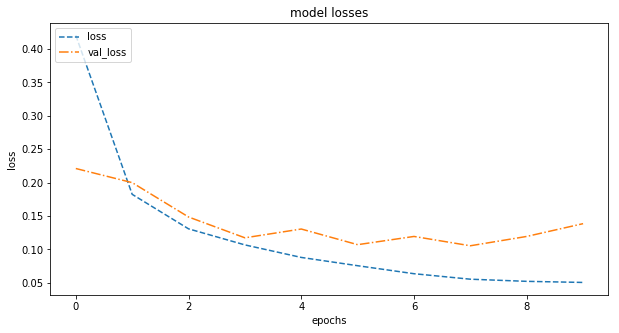

In [12]:
# plot the losses
plt.figure(figsize=(10,5))
plt.plot(hist_sol_1.history['loss'], linestyle="--")
plt.plot(hist_sol_1.history['val_loss'], linestyle="-.")
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(["loss", "val_loss"], loc='upper left')
axes = plt.gca()
plt.show()

Accuracy gotten after training:

In [13]:
#load the weights that resulted in the minimal validation loss
model_sol_1.load_weights('mnist.model.best.hdf5')

score = model_sol_1.evaluate(splitted_test_X, ohe_splitted_test_y, verbose=0)
accuracy = 100 * score[1]

#print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 97.1310%


### Making predictions using Solution 1

In [14]:
predictions = model_sol_1.predict(test_x)
predictions = [ np.argmax(x) for x in predictions ]

In [15]:
# prepare submission
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission.drop('Label', axis=1, inplace=True)
submission['Label'] = predictions
submission.to_csv('submission1.csv', index=False)

The prediction obtained by this solution yielded a score of 0.96385.

## Solution 2. Model using Convolutional NNs

In this solution I implement a Convolutional Network to replace my Fully Connected Neural Network from solution1.<br>
It is now well known that convolutional neural networks achieve a superior performance than fully connected networks with way less computational cost. <br>
The architectures designed for any type of classification contain a couple of layers of fully connected nodes at the end, just before the output. This is still needed because even though CNNs can learn more significant information, fully connected nodes are in charge -at least- of the classification part - by means of softmax activation.

In [16]:
extended_splitted_train_X = splitted_train_X[..., tf.newaxis]
extended_splitted_test_X = splitted_test_X[..., tf.newaxis]
extended_splitted_test_X.shape

(8400, 28, 28, 1)

In [17]:
# define a Convolutional NNs model
model_sol_2 = Sequential()
model_sol_2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=extended_splitted_train_X.shape[1:]))
model_sol_2.add(MaxPooling2D(pool_size=2))
model_sol_2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_sol_2.add(MaxPooling2D(pool_size=2))
model_sol_2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_sol_2.add(MaxPooling2D(pool_size=2))

# Converts our 3D feature maps to 1D features vectors
model_sol_2.add(Flatten())
model_sol_2.add(Dense(64))
model_sol_2.add(Activation('relu'))
model_sol_2.add(Dropout(0.2))
model_sol_2.add(Dense(10, activation='softmax'))

# summary of model
#model_sol_2.summary()

I compiled this model using 'rmsprop' optimization, 'categorical_crossentropy' for loss measurement and accuracy as metrics measurement. I am also curious about the accuracy of this model before it has being even trained.

In [18]:
# compile the model
model_sol_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [19]:
# evaluate test accuracy
score = model_sol_2.evaluate(extended_splitted_test_X, ohe_splitted_test_y, verbose=0)
accuracy = 100 * score[1]

# print test accuracy
print('Test accuracy: %4f%%' % accuracy)

Test accuracy: 10.190476%


In [20]:
# checkpointer to save the best weihts
checkpointer = ModelCheckpoint(filepath='mnist.model.best.hdf5', verbose=1, save_best_only=True)

hist_sol_2 = model_sol_2.fit(extended_splitted_train_X, ohe_splitted_train_y, batch_size=128,
                             epochs=10, callbacks=[checkpointer],
                             verbose=2, validation_data=(extended_splitted_test_X, ohe_splitted_test_y), shuffle=True)

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
 - 2s - loss: 0.4708 - accuracy: 0.8523 - val_loss: 0.1357 - val_accuracy: 0.9574

Epoch 00001: val_loss improved from inf to 0.13566, saving model to mnist.model.best.hdf5
Epoch 2/10
 - 2s - loss: 0.1272 - accuracy: 0.9615 - val_loss: 0.0902 - val_accuracy: 0.9694

Epoch 00002: val_loss improved from 0.13566 to 0.09016, saving model to mnist.model.best.hdf5
Epoch 3/10
 - 2s - loss: 0.0820 - accuracy: 0.9746 - val_loss: 0.0718 - val_accuracy: 0.9768

Epoch 00003: val_loss improved from 0.09016 to 0.07178, saving model to mnist.model.best.hdf5
Epoch 4/10
 - 2s - loss: 0.0638 - accuracy: 0.9808 - val_loss: 0.0551 - val_accuracy: 0.9836

Epoch 00004: val_loss improved from 0.07178 to 0.05509, saving model to mnist.model.best.hdf5
Epoch 5/10
 - 2s - loss: 0.0516 - accuracy: 0.9849 - val_loss: 0.0484 - val_accuracy: 0.9836

Epoch 00005: val_loss improved from 0.05509 to 0.04836, saving model to mnist.model.best.hdf5
Epoch 6/10
 - 2

### Complexity graph of Solution 2

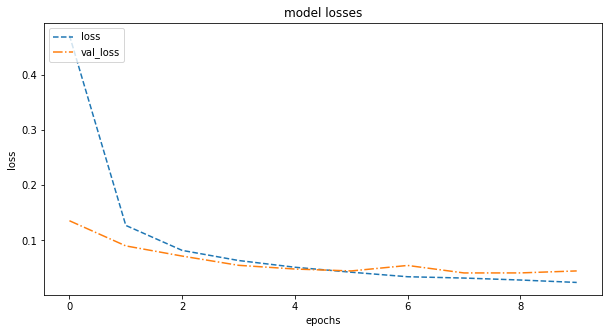

In [21]:
# plot the losses
plt.figure(figsize=(10,5))
plt.plot(hist_sol_2.history['loss'], linestyle="--")
plt.plot(hist_sol_2.history['val_loss'], linestyle="-.")
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(["loss", "val_loss"], loc='upper left')
axes = plt.gca()
plt.show()

In [22]:
#load the weights that resulted in the minimal validation loss
model_sol_2.load_weights('mnist.model.best.hdf5')

score = model_sol_2.evaluate(extended_splitted_test_X, ohe_splitted_test_y, verbose=0)
accuracy = 100 * score[1]

#print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 98.5714%


### Making predictions using Solution 2

In [23]:
# extend the test imagae set with an additional dimension
extended_test_x = test_x[..., tf.newaxis]
predictions = model_sol_2.predict(extended_test_x)
predictions = [ np.argmax(x) for x in predictions ]

# prepare submission
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission.drop('Label', axis=1, inplace=True)
submission['Label'] = predictions
submission.to_csv('submission2.csv', index=False)

The prediction obtained by this solution yielded a score of 0.98671.

## Solution 3. Model using Convolutional NNs with data augmentation

In this solution I make use of the model architecture of solution number 2 but I also implement data augmentation for the training. <br>
Data augmentation that I am implementing here consist of:
* rotating the image with a range of -10 to 10 degrees
* shifting 10 percent the image both widthwise and heightwise directions
* zooming up to a 10 percent the images

These augmentation is applied randomly and differently to each image.

### Augmenting an image

In [24]:
# define a data augmentator for our images
image_augmentator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # rescale=1./255,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode='nearest')

# define size of batch
batch_size = 32

train_batches = image_augmentator.flow(extended_splitted_train_X, ohe_splitted_train_y, batch_size=batch_size)
val_batches = image_augmentator.flow(extended_splitted_test_X, ohe_splitted_test_y, batch_size=batch_size)

Let's look at an example of data augmentation:

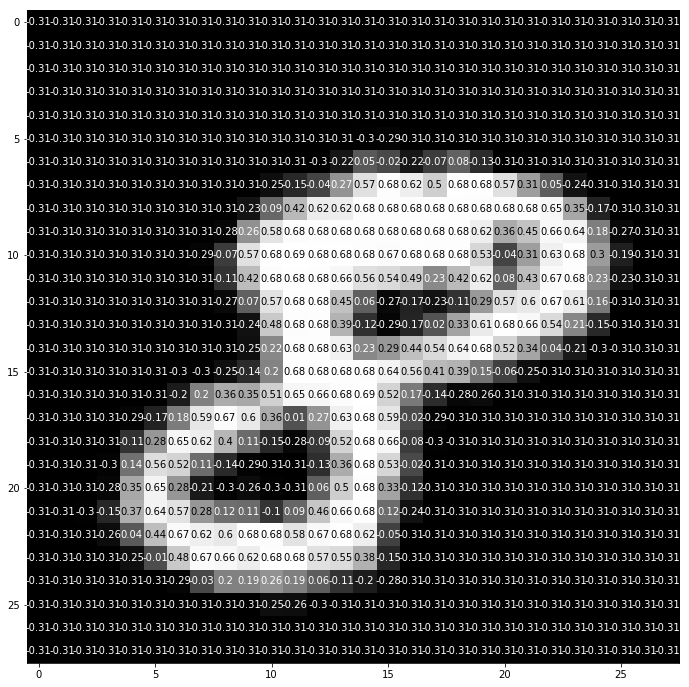

In [25]:
example_img = train_x[10][..., tf.newaxis]
transf_params = { 'theta':15., 'tx':0.1, 'ty':0.1, 'shear':0.2 }
augmented_image = image_augmentator.apply_transform(example_img, transf_params)

# reducing dimensinoality to two
twoDim_image = augmented_image[:, :, 0]

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
visualize_detail(twoDim_image, ax)

In [26]:
# define a Convolutional NNs model (solution number 3)
model_sol_3 = Sequential()
model_sol_3.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=extended_splitted_train_X.shape[1:]))
model_sol_3.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model_sol_3.add(MaxPooling2D(pool_size=2))
model_sol_3.add(Dropout(0.1))
model_sol_3.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model_sol_3.add(MaxPooling2D(pool_size=2))

# Converts our 3D feature maps to 1D features vectors
model_sol_3.add(Flatten())
model_sol_3.add(Dense(64))
model_sol_3.add(Activation('relu'))
model_sol_3.add(Dropout(0.2))
model_sol_3.add(Dense(10, activation='softmax'))

# summary of model
#model_sol_3.summary()

In [27]:
# compile the model
model_sol_3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [28]:
# checkpointer to save the best weihts
checkpointer = ModelCheckpoint(filepath='mnist.model.best.hdf5', verbose=1, save_best_only=True)

hist_sol_3 = model_sol_3.fit_generator(generator=train_batches, steps_per_epoch =extended_splitted_train_X.shape[0] // batch_size,
                                       epochs=32, callbacks=[checkpointer],
                                       validation_data=val_batches, validation_steps=extended_splitted_test_X.shape[0] // batch_size,
                                       verbose=2)

Epoch 1/32
 - 25s - loss: 0.5003 - accuracy: 0.8400 - val_loss: 0.2695 - val_accuracy: 0.9400

Epoch 00001: val_loss improved from inf to 0.26952, saving model to mnist.model.best.hdf5
Epoch 2/32
 - 24s - loss: 0.1900 - accuracy: 0.9414 - val_loss: 0.3121 - val_accuracy: 0.9656

Epoch 00002: val_loss did not improve from 0.26952
Epoch 3/32
 - 24s - loss: 0.1379 - accuracy: 0.9594 - val_loss: 0.0521 - val_accuracy: 0.9719

Epoch 00003: val_loss improved from 0.26952 to 0.05209, saving model to mnist.model.best.hdf5
Epoch 4/32
 - 23s - loss: 0.1162 - accuracy: 0.9659 - val_loss: 0.0204 - val_accuracy: 0.9759

Epoch 00004: val_loss improved from 0.05209 to 0.02044, saving model to mnist.model.best.hdf5
Epoch 5/32
 - 23s - loss: 0.1060 - accuracy: 0.9683 - val_loss: 0.0503 - val_accuracy: 0.9756

Epoch 00005: val_loss did not improve from 0.02044
Epoch 6/32
 - 23s - loss: 0.0984 - accuracy: 0.9703 - val_loss: 0.0833 - val_accuracy: 0.9775

Epoch 00006: val_loss did not improve from 0.02044

### Complexity graph of Solution 3

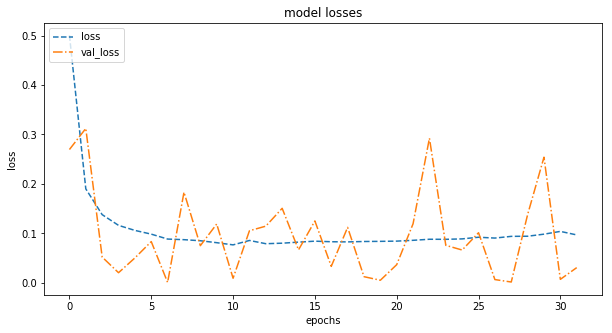

In [29]:
# plot the losses
plt.figure(figsize=(10,5))
plt.plot(hist_sol_3.history['loss'], linestyle="--")
plt.plot(hist_sol_3.history['val_loss'], linestyle="-.")
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(["loss", "val_loss"], loc='upper left')
axes = plt.gca()
plt.show()

In [30]:
#load the weights that resulted in the minimal validation loss
model_sol_3.load_weights('mnist.model.best.hdf5')

score = model_sol_3.evaluate(extended_splitted_test_X, ohe_splitted_test_y, verbose=0)
accuracy = 100 * score[1]

#print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 98.5833%


### Making predictions using Solution 3

In [31]:
# extend the test imagae set with an additional dimension
extended_test_x = test_x[..., tf.newaxis]
predictions = model_sol_3.predict(extended_test_x)
predictions = [ np.argmax(x) for x in predictions ]

# prepare submission
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission.drop('Label', axis=1, inplace=True)
submission['Label'] = predictions
submission.to_csv('submission3.csv', index=False)

The prediction obtained by this solution yielded a score of 0.98885.

## Solution 4. Model using Convolutional NNs with data augmentation and batch normalization

For this solution I wanted to add Batch normalization to my previous solution. I wanted to see if there were any improvement on doing this. Here I want to see / compare if there are any significant difference in adding more feature maps to my CNN. So I prepared two CNNs with batch normalization (again, taking my previous solution as a base). The first CNN (i.e. solution 4_1) with 16 feature maps in all my convolutional layers an the second solution (i.e. solution 4_2) with 32 fetaure maps in its convolutional layers.

### Solution 4_1 - Convolutional layers with 16 feature maps

In [32]:
# define a Convolutional NNs model (solution number 4)
model_sol_4_1 = Sequential()
model_sol_4_1.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=extended_splitted_train_X.shape[1:]))
model_sol_4_1.add(BatchNormalization())
model_sol_4_1.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model_sol_4_1.add(MaxPooling2D(pool_size=2))
model_sol_4_1.add(Dropout(0.1))
model_sol_4_1.add(BatchNormalization())
model_sol_4_1.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model_sol_4_1.add(MaxPooling2D(pool_size=2))

# Converts our 3D feature maps to 1D features vectors
model_sol_4_1.add(Flatten())
model_sol_4_1.add(BatchNormalization())
model_sol_4_1.add(Dense(64))
model_sol_4_1.add(Activation('relu'))
model_sol_4_1.add(Dropout(0.2))
model_sol_4_1.add(BatchNormalization())
model_sol_4_1.add(Dense(10, activation='softmax'))

# summary of model
#model_sol_4_1.summary()

In [33]:
# compile the model
model_sol_4_1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [34]:
# checkpointer to save the best weihts
checkpointer = ModelCheckpoint(filepath='mnist.model.best.hdf5', verbose=1, save_best_only=True)

hist_sol_4 = model_sol_4_1.fit_generator(generator=train_batches, steps_per_epoch =extended_splitted_train_X.shape[0] // batch_size,
                                       epochs=32, callbacks=[checkpointer],
                                       validation_data=val_batches, validation_steps=extended_splitted_test_X.shape[0] // batch_size,
                                       verbose=2)

Epoch 1/32
 - 31s - loss: 0.4289 - accuracy: 0.8665 - val_loss: 0.0269 - val_accuracy: 0.9599

Epoch 00001: val_loss improved from inf to 0.02686, saving model to mnist.model.best.hdf5
Epoch 2/32
 - 29s - loss: 0.1846 - accuracy: 0.9432 - val_loss: 0.2081 - val_accuracy: 0.9707

Epoch 00002: val_loss did not improve from 0.02686
Epoch 3/32
 - 29s - loss: 0.1464 - accuracy: 0.9548 - val_loss: 0.0796 - val_accuracy: 0.9736

Epoch 00003: val_loss did not improve from 0.02686
Epoch 4/32
 - 29s - loss: 0.1249 - accuracy: 0.9623 - val_loss: 0.1011 - val_accuracy: 0.9734

Epoch 00004: val_loss did not improve from 0.02686
Epoch 5/32
 - 30s - loss: 0.1176 - accuracy: 0.9643 - val_loss: 0.1325 - val_accuracy: 0.9767

Epoch 00005: val_loss did not improve from 0.02686
Epoch 6/32
 - 29s - loss: 0.1080 - accuracy: 0.9670 - val_loss: 0.1290 - val_accuracy: 0.9821

Epoch 00006: val_loss did not improve from 0.02686
Epoch 7/32
 - 29s - loss: 0.0989 - accuracy: 0.9693 - val_loss: 0.1313 - val_accuracy

### Complexity graph of Solution 4_1

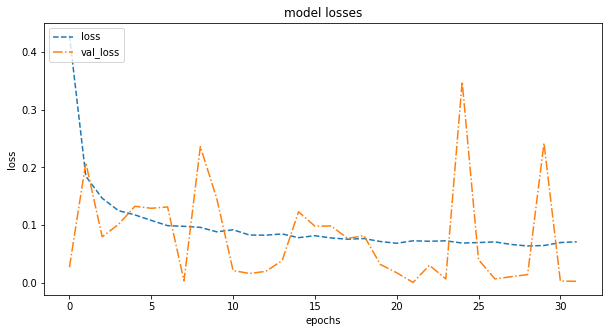

In [35]:
# plot the losses
plt.figure(figsize=(10,5))
plt.plot(hist_sol_4.history['loss'], linestyle="--")
plt.plot(hist_sol_4.history['val_loss'], linestyle="-.")
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(["loss", "val_loss"], loc='upper left')
axes = plt.gca()
plt.show()

In [36]:
#load the weights that resulted in the minimal validation loss
model_sol_4_1.load_weights('mnist.model.best.hdf5')

score = model_sol_4_1.evaluate(extended_splitted_test_X, ohe_splitted_test_y, verbose=0)
accuracy = 100 * score[1]

#print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 98.9048%


### Solution 4_2 - Convolutional layers with 32 feature maps

In [37]:
model_sol_4_2 = Sequential()
model_sol_4_2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=extended_splitted_train_X.shape[1:]))
model_sol_4_2.add(BatchNormalization())
model_sol_4_2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_sol_4_2.add(MaxPooling2D(pool_size=2))
model_sol_4_2.add(Dropout(0.1))
model_sol_4_2.add(BatchNormalization())
model_sol_4_2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_sol_4_2.add(MaxPooling2D(pool_size=2))

# Converts our 3D feature maps to 1D features vectors
model_sol_4_2.add(Flatten())
model_sol_4_2.add(BatchNormalization())
model_sol_4_2.add(Dense(64))
model_sol_4_2.add(Activation('relu'))
model_sol_4_2.add(Dropout(0.2))
model_sol_4_2.add(BatchNormalization())
model_sol_4_2.add(Dense(10, activation='softmax'))

# summary of model
#model_sol_4_2.summary()

In [38]:
# compile the model
model_sol_4_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [39]:
# checkpointer to save the best weihts
checkpointer = ModelCheckpoint(filepath='mnist.model.best.hdf5', verbose=1, save_best_only=True)

hist_sol_4 = model_sol_4_2.fit_generator(generator=train_batches, steps_per_epoch=extended_splitted_train_X.shape[0] // batch_size,
                                       epochs=32, callbacks=[checkpointer],
                                       validation_data=val_batches, validation_steps=extended_splitted_test_X.shape[0] // batch_size,
                                       verbose=2)

Epoch 1/32
 - 31s - loss: 0.3264 - accuracy: 0.9013 - val_loss: 0.2428 - val_accuracy: 0.9266

Epoch 00001: val_loss improved from inf to 0.24281, saving model to mnist.model.best.hdf5
Epoch 2/32
 - 30s - loss: 0.1430 - accuracy: 0.9563 - val_loss: 0.2519 - val_accuracy: 0.9596

Epoch 00002: val_loss did not improve from 0.24281
Epoch 3/32
 - 30s - loss: 0.1136 - accuracy: 0.9664 - val_loss: 0.0431 - val_accuracy: 0.9773

Epoch 00003: val_loss improved from 0.24281 to 0.04308, saving model to mnist.model.best.hdf5
Epoch 4/32
 - 30s - loss: 0.1010 - accuracy: 0.9684 - val_loss: 0.0807 - val_accuracy: 0.9796

Epoch 00004: val_loss did not improve from 0.04308
Epoch 5/32
 - 29s - loss: 0.0896 - accuracy: 0.9730 - val_loss: 0.0063 - val_accuracy: 0.9811

Epoch 00005: val_loss improved from 0.04308 to 0.00630, saving model to mnist.model.best.hdf5
Epoch 6/32
 - 29s - loss: 0.0837 - accuracy: 0.9748 - val_loss: 0.0066 - val_accuracy: 0.9816

Epoch 00006: val_loss did not improve from 0.00630

### Complexity graph of Solution 4_2

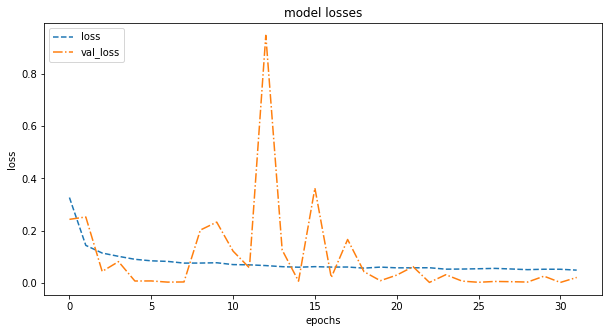

In [40]:
# plot the losses
plt.figure(figsize=(10,5))
plt.plot(hist_sol_4.history['loss'], linestyle="--")
plt.plot(hist_sol_4.history['val_loss'], linestyle="-.")
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(["loss", "val_loss"], loc='upper left')
axes = plt.gca()
plt.show()

In [41]:
#load the weights that resulted in the minimal validation loss
model_sol_4_2.load_weights('mnist.model.best.hdf5')

score = model_sol_4_2.evaluate(extended_splitted_test_X, ohe_splitted_test_y, verbose=0)
accuracy = 100 * score[1]

#print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 99.1190%


### Making predictions using Solution 4

From these two CNNs, that with more feature maps (i.e. solution 4_2 with 32 feature maps) yielded a higher test accuracy. I used that model to make the predictions on this part of the notebook.

In [42]:
extended_test_x = test_x[..., tf.newaxis]
predictions = model_sol_4_2.predict(extended_test_x)
predictions = [ np.argmax(x) for x in predictions ]

# prepare submission
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission.drop('Label', axis=1, inplace=True)
submission['Label'] = predictions
submission.to_csv('submission4.csv', index=False)

**The prediction obtained by this solution yielded a score of 0.99542.**

## Solution 5. Adding a Lambda layer to my last CNN

I will try again, but this time I will add a Lambda layer at the input of my NN. This layer input will center the data around zero mean and unite variance (I got this from [Poonam Ligade's notebook](https://www.kaggle.com/poonaml/deep-neural-network-keras-way/notebook)). This means I have to take again the original data (not preprocessed data), and add another dimension.<br>
The Lambda layer will perform a "Standardize" function (defined later some blocks below) which will do the preprocessing to each one of the images (i.e. as mentioned before, center the data around zero mean and unit variance).
<br>
I will also change the optimizer of my network in favor of [Adam](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c) and will add [Ridge regression](https://towardsdatascience.com/ridge-regression-for-better-usage-2f19b3a202db) to the first convolutional layer of my neural network in an attempt to penalize more those feature of the images that does not help the algorithm to improve during its training.

In [43]:
# create new datasets out of the original files provided by kaggle (to avoid confussions with other
# variables created in other sections of this notebook and because I need this data without the first preprocessing steps
# I performed in my previous solutions)
train_y_sol5 = mnist_train_complete.iloc[:, 0].values.astype('int32')
train_x_sol5 = mnist_train_complete.iloc[:, 1:].values.astype('float32')
test_x_sol5 =  mnist_test_complete.values.astype('float32')

# reshaping the new training and testing sets to have each digit image of 28 by 28 pixels
train_x_sol5 = train_x_sol5.reshape(train_x_sol5.shape[0], 28, 28)
test_x_sol5 = test_x_sol5.reshape(test_x_sol5.shape[0], 28, 28)

# add another dimension to the training data
train_x_sol5 = train_x_sol5[..., tf.newaxis]
test_x_sol5  = test_x_sol5[..., tf.newaxis]

Below there is the definition of the standardizer function, which will "preprocess" each one of the images as they are fed to the CNN.

In [44]:
# new preprocessing of data (to be applied to each individual image by the Lamda layer)
mean_px = train_x_sol5.mean().astype(np.float32)
std_px = train_x_sol5.std().astype(np.float32)

# define the function that will be performed by our Lambda layer on each of the input images
def standardize(x): 
    return (x-mean_px)/std_px

In [45]:
# cross validation
s5_train_x, s5_test_x, s5_train_y, s5_test_y = train_test_split(train_x_sol5, train_y_sol5,
                                                                test_size=0.2,
                                                                random_state=81)
# one-hot encoding the target labels
ohe_s5_train_y = tf_utils.to_categorical(s5_train_y, 10)
ohe_s5_test_y = tf_utils.to_categorical(s5_test_y, 10)

# create new image generators using the same image_augmentator created previously,
# but with a different number of batches (prevous batch size was 32).
train_batches_sol5 = image_augmentator.flow(s5_train_x, ohe_s5_train_y, batch_size=64)
val_batches_sol5 = image_augmentator.flow(s5_test_x, ohe_s5_test_y, batch_size=64)

In [46]:
model_sol_5 = Sequential()
model_sol_5.add(Lambda(standardize, input_shape=(28,28,1)))
model_sol_5.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                 kernel_regularizer=regularizers.l2(0.1),
                 ))
model_sol_5.add(BatchNormalization())
model_sol_5.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'
                ))
model_sol_5.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.1))

model_sol_5.add(BatchNormalization())
model_sol_5.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'
         ))
model_sol_5.add(MaxPooling2D(pool_size=2))

# Converts our 3D feature maps to 1D features vectors
model_sol_5.add(Flatten())
model_sol_5.add(BatchNormalization())
model_sol_5.add(Dense(64))
model_sol_5.add(Activation('relu'))
model_sol_5.add(Dropout(0.2))
model_sol_5.add(BatchNormalization())
model_sol_5.add(Dense(10, activation='softmax'))

# summary of model
#model_sol_5.summary()

In [47]:
# compile the model
model_sol_5.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [48]:
# checkpointer to save the best weihts
checkpointer = ModelCheckpoint(filepath='mnist.model.best.hdf5', verbose=1, save_best_only=True)

hist_sol_5 = model_sol_5.fit_generator(generator=train_batches_sol5, steps_per_epoch=s5_train_x.shape[0] // 64,
                                       epochs=32, callbacks=[checkpointer],
                                       validation_data=val_batches_sol5, validation_steps=s5_test_x.shape[0] // 64, verbose=2)

Epoch 1/32
 - 24s - loss: 0.4308 - accuracy: 0.8990 - val_loss: 2.4179 - val_accuracy: 0.5072

Epoch 00001: val_loss improved from inf to 2.41789, saving model to mnist.model.best.hdf5
Epoch 2/32
 - 22s - loss: 0.1561 - accuracy: 0.9585 - val_loss: 0.1030 - val_accuracy: 0.9668

Epoch 00002: val_loss improved from 2.41789 to 0.10297, saving model to mnist.model.best.hdf5
Epoch 3/32
 - 22s - loss: 0.1227 - accuracy: 0.9652 - val_loss: 0.0924 - val_accuracy: 0.9681

Epoch 00003: val_loss improved from 0.10297 to 0.09237, saving model to mnist.model.best.hdf5
Epoch 4/32
 - 22s - loss: 0.1032 - accuracy: 0.9715 - val_loss: 0.0606 - val_accuracy: 0.9533

Epoch 00004: val_loss improved from 0.09237 to 0.06060, saving model to mnist.model.best.hdf5
Epoch 5/32
 - 22s - loss: 0.0919 - accuracy: 0.9749 - val_loss: 0.0437 - val_accuracy: 0.9621

Epoch 00005: val_loss improved from 0.06060 to 0.04366, saving model to mnist.model.best.hdf5
Epoch 6/32
 - 22s - loss: 0.0861 - accuracy: 0.9764 - val_l

### Complexity graph of Solution 5

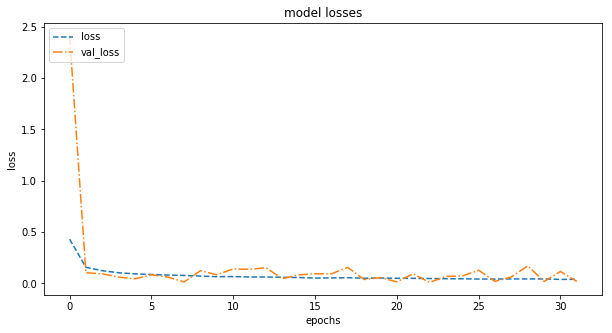

In [49]:
# plot the losses
plt.figure(figsize=(10,5))
plt.plot(hist_sol_5.history['loss'], linestyle="--")
plt.plot(hist_sol_5.history['val_loss'], linestyle="-.")
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(["loss", "val_loss"], loc='upper left')
axes = plt.gca()
plt.show()

In [50]:
#load the weights that resulted in the minimal validation loss
model_sol_5.load_weights('mnist.model.best.hdf5')

score = model_sol_5.evaluate(s5_test_x, ohe_s5_test_y, verbose=0)
accuracy = 100 * score[1]

#print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 98.7381%


### Making predictions using Solution 5

In [51]:
predictions = model_sol_5.predict(test_x_sol5)
predictions = [ np.argmax(x) for x in predictions ]

# prepare submission
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission.drop('Label', axis=1, inplace=True)
submission['Label'] = predictions
submission.to_csv('submission5.csv', index=False)

The prediction obtained by this solution yielded a score of 0.99257.<br>
**Note**: After obtaining a lower score, I did try again the same network with the difference of removing the Dropout of 1% between convolutional layers (i.e. see the commented dropout), obtaining a score of **0.99342** (still lower than the score obtained with Solution 4).

# Solution 6. Two step training approach

The network on Solution 5 threw actually a worst score than Solution 4 even though I added Ridge regression (i.e. L2 regularization) to the first layer. To me seems to be clear that this L2 regularization hindered a little bit the training. This might be due to the fact that some "features" (i.e. pixels) do not have always the same "meaning". The same pixel will have different information on different images, depending on the position of the number that an image contains, plus the data augmentation that comes on top of some images. Therefore, it is my opinion that using L2 regularization brings not benefit at all here.
<br><br>
In this solution I wanted to try a 2 step training approach (which I also saw in [Poonam Ligade's notebook](https://www.kaggle.com/poonaml/deep-neural-network-keras-way/notebook) but I did not think it would be really necessary because I though that by using L2 regularization I would get way better results - I was cleary wrong about L2).<br>
Since my las solution (i.e. Solution 5) produced a negative result - meaning no improvement in the score - I will retake solution number 4 as the base of this solution (i.e. Solution 6) with the only addition of the lambda layer at the beginning of the CNN architecture and using adam as the optimizer when compiling the model. Also, before attempting the second training step, I will set the learning rate of the optimazer to 1% instead of its default value of 0.01%.<br>
Let's see what this two trainig approach (without L2 regularization) have to offer!

In [52]:
model_sol_6 = Sequential()
model_sol_6.add(Lambda(standardize, input_shape=(28,28,1)))
model_sol_6.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_sol_6.add(BatchNormalization())
model_sol_6.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_sol_6.add(MaxPooling2D(pool_size=2))
model_sol_6.add(Dropout(0.1))
model_sol_6.add(BatchNormalization())
model_sol_6.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_sol_6.add(MaxPooling2D(pool_size=2))

# Converts our 3D feature maps to 1D features vectors
model_sol_6.add(Flatten())
model_sol_6.add(BatchNormalization())
model_sol_6.add(Dense(64))
model_sol_6.add(Activation('relu'))
model_sol_6.add(Dropout(0.2))
model_sol_6.add(BatchNormalization())
model_sol_6.add(Dense(10, activation='softmax'))

# summary of model
#model_sol_6.summary()

In [53]:
# compile the model
model_sol_6.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [54]:
# checkpointer to save the best weihts
checkpointer = ModelCheckpoint(filepath='mnist.model.best.hdf5', verbose=1, save_best_only=True)

hist_sol_6 = model_sol_6.fit_generator(generator=train_batches_sol5, steps_per_epoch=s5_train_x.shape[0] // 64,
                                       epochs=32, callbacks=[checkpointer],
                                       validation_data=val_batches_sol5, validation_steps=s5_test_x.shape[0] // 64, verbose=2)

Epoch 1/32
 - 24s - loss: 0.3909 - accuracy: 0.8830 - val_loss: 0.4235 - val_accuracy: 0.8408

Epoch 00001: val_loss improved from inf to 0.42351, saving model to mnist.model.best.hdf5
Epoch 2/32
 - 23s - loss: 0.1442 - accuracy: 0.9572 - val_loss: 0.1280 - val_accuracy: 0.9747

Epoch 00002: val_loss improved from 0.42351 to 0.12802, saving model to mnist.model.best.hdf5
Epoch 3/32
 - 22s - loss: 0.1081 - accuracy: 0.9672 - val_loss: 0.1302 - val_accuracy: 0.9758

Epoch 00003: val_loss did not improve from 0.12802
Epoch 4/32
 - 22s - loss: 0.0904 - accuracy: 0.9728 - val_loss: 0.0530 - val_accuracy: 0.9825

Epoch 00004: val_loss improved from 0.12802 to 0.05303, saving model to mnist.model.best.hdf5
Epoch 5/32
 - 23s - loss: 0.0862 - accuracy: 0.9732 - val_loss: 0.0586 - val_accuracy: 0.9820

Epoch 00005: val_loss did not improve from 0.05303
Epoch 6/32
 - 23s - loss: 0.0754 - accuracy: 0.9770 - val_loss: 0.0262 - val_accuracy: 0.9796

Epoch 00006: val_loss improved from 0.05303 to 0.0

### Complexity graph of Solution 6

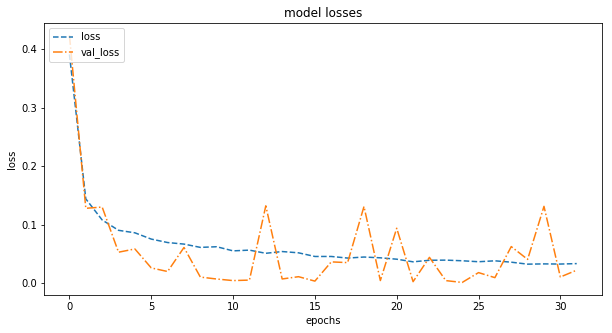

In [55]:
# plot the losses
plt.figure(figsize=(10,5))
plt.plot(hist_sol_6.history['loss'], linestyle="--")
plt.plot(hist_sol_6.history['val_loss'], linestyle="-.")
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(["loss", "val_loss"], loc='upper left')
axes = plt.gca()
plt.show()

In [56]:
#load the weights that resulted in the minimal validation loss
model_sol_6.load_weights('mnist.model.best.hdf5')

score = model_sol_6.evaluate(s5_test_x, ohe_s5_test_y, verbose=0)
accuracy = 100 * score[1]

#print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 99.3571%


Performing the second step of the training process...

In [57]:
model_sol_6.optimizer.lerning_rate=0.01
gen = ImageDataGenerator()
batches = gen.flow(train_x_sol5, tf_utils.to_categorical(train_y_sol5, 10), batch_size=64)
hist_sol_6 = model_sol_6.fit_generator(generator=batches, steps_per_epoch=train_x_sol5.shape[0] // 64,
                          epochs=50, verbose=2)
# I didn't use a callback on this training step becuase the 'checkpointer' callback I defined works only when
# the model produces validation loss metrics. In order to do that, I need to pass validation data to the
# fit_generator method. For this second training step I did not pass such validation data becase we do not have 
# test data to validate against - now I am using the complete set of images provided by kaggle.

Epoch 1/50
 - 10s - loss: 0.0265 - accuracy: 0.9920
Epoch 2/50
 - 10s - loss: 0.0182 - accuracy: 0.9942
Epoch 3/50
 - 10s - loss: 0.0168 - accuracy: 0.9946
Epoch 4/50
 - 10s - loss: 0.0150 - accuracy: 0.9950
Epoch 5/50
 - 10s - loss: 0.0137 - accuracy: 0.9955
Epoch 6/50
 - 10s - loss: 0.0118 - accuracy: 0.9964
Epoch 7/50
 - 10s - loss: 0.0123 - accuracy: 0.9960
Epoch 8/50
 - 10s - loss: 0.0103 - accuracy: 0.9967
Epoch 9/50
 - 10s - loss: 0.0109 - accuracy: 0.9968
Epoch 10/50
 - 10s - loss: 0.0108 - accuracy: 0.9967
Epoch 11/50
 - 10s - loss: 0.0079 - accuracy: 0.9973
Epoch 12/50
 - 10s - loss: 0.0102 - accuracy: 0.9964
Epoch 13/50
 - 10s - loss: 0.0081 - accuracy: 0.9972
Epoch 14/50
 - 10s - loss: 0.0083 - accuracy: 0.9973
Epoch 15/50
 - 10s - loss: 0.0082 - accuracy: 0.9972
Epoch 16/50
 - 10s - loss: 0.0058 - accuracy: 0.9981
Epoch 17/50
 - 10s - loss: 0.0074 - accuracy: 0.9974
Epoch 18/50
 - 10s - loss: 0.0056 - accuracy: 0.9982
Epoch 19/50
 - 10s - loss: 0.0067 - accuracy: 0.9975
Ep

### Making predictions using Solution 6

In [58]:
predictions = model_sol_6.predict(test_x_sol5)
predictions = [ np.argmax(x) for x in predictions ]

# prepare submission
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission.drop('Label', axis=1, inplace=True)
submission['Label'] = predictions
submission.to_csv('submission6.csv', index=False)

The prediction obtained by this solution yielded a score of 0.99185, but still lower than our best score of Solution 4.

In [59]:
os.remove('submission1.csv')
os.remove('submission2.csv')
os.remove('submission3.csv')
os.remove('submission4.csv')
os.remove('submission5.csv')
os.remove('submission6.csv')

## Final submission

The final submission is done using the model that yielded in the best score - in this notebook that is the model 4_2 - I just decided to compile it using 'Adam' as optimizer because it finds local minima faster (even though it has its own cons).

In [60]:
final_train_x = train_x[..., tf.newaxis]
final_ohe_train_y = tf_utils.to_categorical(train_y, 10)
final_train_batches = image_augmentator.flow(final_train_x, final_ohe_train_y, batch_size=64)

final_model = Sequential()
final_model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=extended_splitted_train_X.shape[1:]))
final_model.add(BatchNormalization())
final_model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
final_model.add(MaxPooling2D(pool_size=2))
final_model.add(Dropout(0.1))
final_model.add(BatchNormalization())
final_model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
final_model.add(MaxPooling2D(pool_size=2))

# Converts our 3D feature maps to 1D features vectors
final_model.add(Flatten())
final_model.add(BatchNormalization())
final_model.add(Dense(64))
final_model.add(Activation('relu'))
final_model.add(Dropout(0.2))
final_model.add(BatchNormalization())
final_model.add(Dense(10, activation='softmax'))

# compile the model
final_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

final_model.fit_generator(generator=final_train_batches, steps_per_epoch=final_train_batches.n,
                          epochs=1, verbose=1)

Epoch 1/1
23821/42000 [================>.............] - ETA: 11:58 - loss: 0.0565 - accuracy: 0.9827

In [61]:
predictions = final_model.predict(test_x[..., tf.newaxis])
predictions = [ np.argmax(x) for x in predictions ]

# prepare submission
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission.drop('Label', axis=1, inplace=True)
submission['Label'] = predictions
submission.to_csv('submission.csv', index=False)

## Conclusion

For me it is difficult to stop trying to expand, modify and introduce more and more ideas into my model mainly because it is not easy to "see" where the line of enough is enough is drawn. A couple of times I lost myself trying more and more things that at the end didn't bring any significan benefit. I decided to remove those from this kernel. <br><br>
From the work on this notebook, it seems to be that both L2 regularization and the computation done with the lambda layer are not bringing benefit to the problem of image classification in the context of MNIST. I think, the mean centered might be different on each image and this might not help to the learning process of the CNN - this could be analyzed in a separate notebook.<br>
~~From the complexity graphs, I can see that from all the solutions implemented in this notebook, solution 2 and solution 4 presented a certain level of stabilization on the last epochs. This is an indication that the CNN reached a local minima point and it was not getting out of it. Obviously such minima point was optimal in Solution 4~~.<br>
After running the notebook again I realized that the complexity graphs were completely different. They looked all "spiky-bumpy" all over the graph. Maybe this is due to the fact that during training the model is validating with augmented images (as it is doing with the training) and in batches. Maybe it'd be needed a longer number of epochs and to train also with the not-augmented images until I can get lines that tend to me more stable (I,d love to hear opinions/knowledge on this point from other users ).

The [kernel](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist) from Chris Deotte inspired me to make a similar investigation on whether the lamda layer I added in my CNN number 5, the L2 regularization and the initial preprocessing of the data I did at the begining bring any real improvement to the predictions.<br><br>
**If you have any suggestion or observation to this work, I will be more than happy to hear from you - and to learn more!**